In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from data_processing.neural_networks.RL_Reinforced_Learning.RL_funcs import (base_env, rew_ep_plot);
from IPython.display import clear_output
clear_output()
from misc_tools.print_latex import print_tex
plt.rcParams['figure.figsize'] = [4, 2]

input example : 
>>> arr_T = np.array([[r'\vec{v}_1', r'\vec{v}_2']]).T
>>> print_tex(arr_T,'=', np.arange(1,5).reshape(2,-1)/4, r'; symbols: \otimes, \cdot,\times')
output: 


<IPython.core.display.Math object>

*   Monte Carlo (MC) waits full episode and makes changes to state/action functions via full return $G_t$ (lets call this quantity a _target_).
    $$G_t \dot = R_{t+1}+ \gamma R_{t+2} + \dots + \gamma^{T- t - 1}R_T$$ 
*   Temporal Differences with 1 step (TD(0)) updates estimate of functions based on immediate reward and estimate of next reward. 
    $$G_{t:t+1} \dot = R_{t+1}+ \gamma V_{t}(S_{t+1})$$
    So TD does estimate based on estimate, which is called bootstrapping. 
    
    It introduces a bias towards previous estimate of state/action function.

    Subscript $t$ in $V_{t}(S_{t+1})$ shows that algorithm uses expected state reward which is up-to-date at time $t$.
    
*   One can try to do updates of state/action functions using parts of episodes and get remaining expected rewards with old state/action function.

    For example using two steps:
    $$G_{t:t+2} \dot = R_{t+1}+ \gamma R_{t+2} +  \gamma^2 V_{t+1}(S_{t+2})$$

    It is still considered a bootstrapping because we do estimate based on estimate, although with lesser extend.

    Its obvious that at time $t$ algorithm does not know $R_{t+2}$, which is in the future, so it has to wait until $t+1$ to get it, and then might as well use most up-to-date $V_{t+1}$.
    
* In general we can analyze n state transitions of an episode, this approach is called _n-step TD method_

    $$G_{t:t+n} \dot = R_{t+1}+ \gamma R_{t+2} + \dots +  \gamma^{n-1} R_{t+n} + \gamma^n V_{t+n -1}(S_{t+n})$$

    By similar logic as in two-step TD, $G_{t:t+n}$ can be evaluated only at $t+n-1$

*   n-step state-value update algorithm then is the following
$$V_{t+n}(S_t) \dot = V_{t+n-1}(S_t) + \alpha \bigg[ G_{t:t+n} - V_{t+n-1}(S_t) \bigg]$$

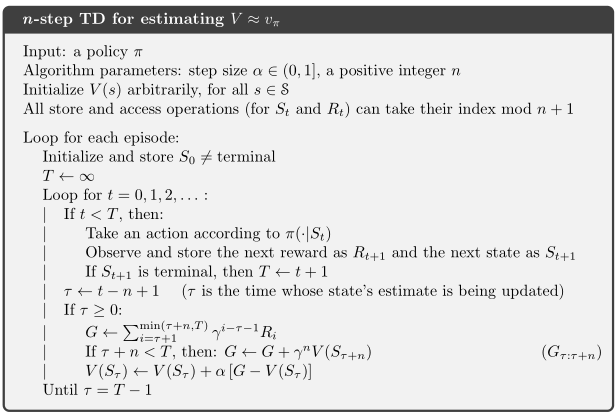

In [19]:
# completely random policy: epsilon = 1.
# env_nTD_V = base_env('FrozenLake-v1', desc=None, map_name="4x4", eps=1)

env_nTD_V = base_env("CliffWalking-v0", eps=0.5)
env_nTD_V.Qsa_init(random=False, action=1)
env_nTD_V.Qsa[37:] *= 0
env_nTD_V.Qsa[36] = [0,1,0,0]
env_nTD_V.policy_update_whole(use_Qsa = True)

In [26]:
def n_step_TD_V(env: base_env, n_steps = 5, N = 1, GAMMA = 1, ALPHA = 0.01):

    tq_iter = tqdm(range(N))
    for i in tq_iter:
        t = 0
        state           = env.reset()    
        mem = [state]
        rews = [-1000]  # dummy reward R_0 so next is R_{t+1}
        T = float("inf")
        while True:
            if t < T:
                action                      = env.sample_action(state, use_Qsa=False)
                state_prime, reward, done   = env.step(action)
                mem.append(state_prime)
                rews.append(reward)
                if done:
                    T = t + 1
            tau = t - n_steps + 1
            if tau >= 0:
                # add +1 to end range to include it.
                G = sum([GAMMA**(i-tau-1)*rews[i] for i in range(tau+1, min(tau+n_steps,T) + 1)])
                if tau + n_steps < T:
                    G += GAMMA**n_steps*env.Vs[mem[tau+n_steps]]
                env.Vs[mem[tau]] = env.Vs[mem[tau]] + ALPHA*(G - env.Vs[mem[tau]])
              
                #tq_iter.set_postfix(eps=env.eps, s = s)
            t += 1
            
            if tau == T - 1:
                break
    return

n_step_TD_V(env_nTD_V, n_steps = 5, N = 2000, GAMMA = 1, ALPHA = 0.01)

100%|██████████| 2000/2000 [00:19<00:00, 103.06it/s]


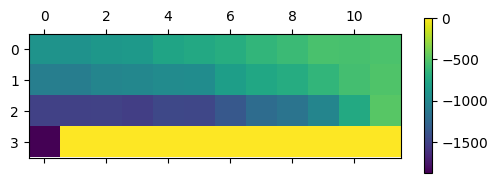

In [25]:
c = plt.matshow(env_nTD_V.Vs.reshape(4,12))
plt.colorbar(c)

## n-step SARSA
